# ZDT Problem Suite

The ZDT benchmark problem suite was created in order to test and compare a variety of multiobjective evolutionary algorithms. Each problem exhibits a number of characteristics the evolutionary algorithm should be expected to overcome, including but not limited to: deceptive fronts, uneven distribution of good solutions, and discontinuities.

Zitzler, Eckart, Kalyanmoy Deb, and Lothar Thiele. "Comparison of multiobjective evolutionary algorithms: Empirical results." *Evolutionary computation* 8.2 (2000): 173-195.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multiprocessing import Pool

from leap_ec.representation import Representation
from leap_ec.ops import tournament_selection, clone, evaluate, pool, UniformCrossover, random_selection
from leap_ec.real_rep.initializers import create_real_vector
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.binary_rep.initializers import create_binary_sequence
from leap_ec.binary_rep.ops import mutate_bitflip

from leap_ec.multiobjective.nsga2 import generalized_nsga_2
from leap_ec.multiobjective.problems import *

plt.rcParams['figure.figsize'] = [6.0, 3.0]
plt.rcParams['figure.dpi'] = 200

SEED=42

Create algorithm structures that are going to be repeated across each of the problems.

For these examples, we are using the following values taken from the NSGA-II paper:
- Population size of 100 individuals
- 250 generations
- Random parent selection

Mutation and crossover operators are included, but do not use the same values as the original paper.

In [2]:
POP_SIZE = 100
MAX_GENERATIONS = 250

# If an individual doesn't have rank and distance attributes, e.g. first candidates, sets their member variables
def _verifiy_multi(pop):
    for ind in pop:
        if not hasattr(ind, "rank"):
            ind.rank = 0
            ind.distance = 0
    return pop

# Setup universally applicable pipeline items
def make_pipeline(*inner_pipeline):
    return [
        _verifiy_multi,
        random_selection,
        clone,
        UniformCrossover(p_swap=0.3), # Crossover is kept consistent between problems
        *inner_pipeline, # Insert inner pipeline, e.g. mutations
        evaluate,
        pool(size=POP_SIZE)
    ]

# Setups kwargs for a real problem, notably a pipeline with a mutate_gaussian operator of the provided parameters
def setup_real(problem, std=0.5, expected_num_mutations=2):
    bounds = problem.bounds
    return {
        "representation": Representation(initialize=create_real_vector(bounds=bounds)),
        "pipeline": make_pipeline(
            mutate_gaussian(std=std, expected_num_mutations=expected_num_mutations, hard_bounds=bounds),
        )
    }

# Converts a population list to a dataframe of some desired attributes
def pop_to_df(population):
    return pd.DataFrame(
        {
            "rank": ind.rank,
            "distance": ind.distance,
            
            **{
                f"f_{i}": fit
                for i, fit in enumerate(ind.fitness)
            }
            
        } for ind in population
    )

# Setup graphing information that is used across all of the functions
graph_kwargs = {
    "x": "f_0", "y": "f_1",
    "hue": "rank", "palette": "flare"
}

## ZTD1

A simple base case with a convex pareto-optimal front.

In [3]:
zdt1_problem = ZDT1Problem()
zdt1_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt1_problem,
    **setup_real(zdt1_problem)
)

Text(0.5, 1.0, 'ZDT1 Pareto Front')

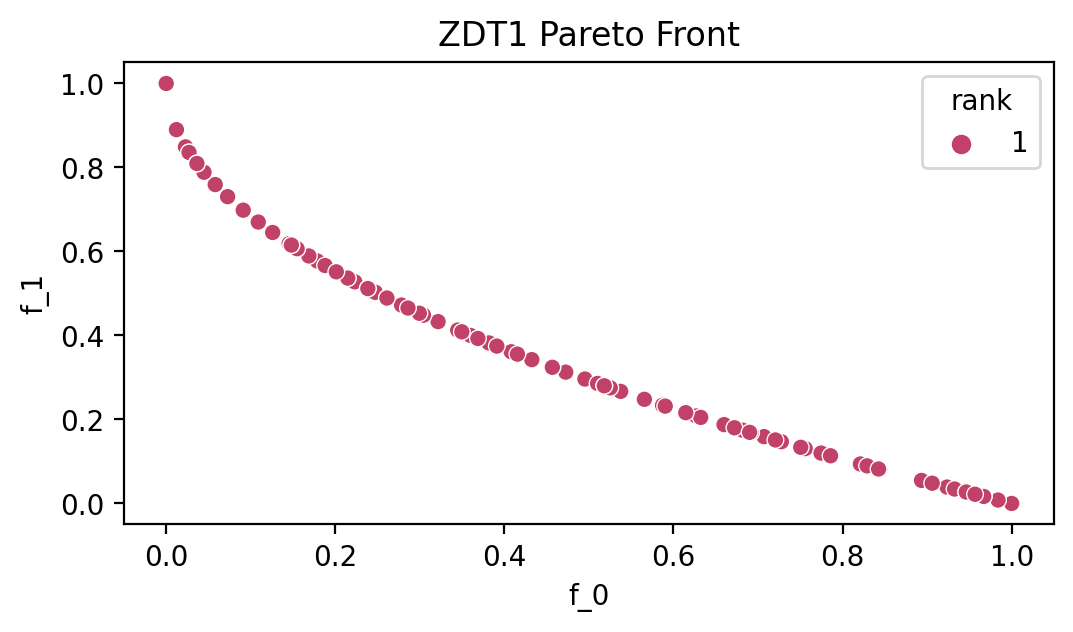

In [4]:
zdt1_df = pop_to_df(zdt1_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt1_df, **graph_kwargs)
ax.set_title("ZDT1 Pareto Front")

## ZTD2

A slightly more deceptive problem with a non-convex pareto-optimal front.

In [5]:
zdt2_problem = ZDT2Problem()
zdt2_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt2_problem,
    **setup_real(zdt2_problem)
)

Text(0.5, 1.0, 'ZDT2 Pareto Front')

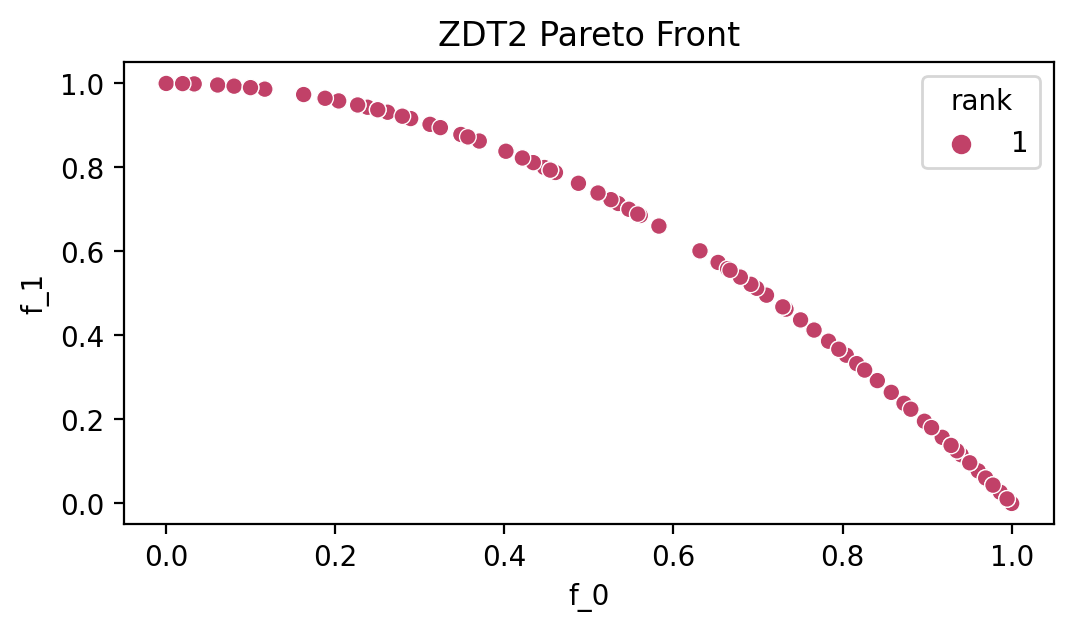

In [6]:
zdt2_df = pop_to_df(zdt2_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt2_df, **graph_kwargs)
ax.set_title("ZDT2 Pareto Front")

## ZDT3

A problem exhibiting discontinuities in the pareto-optimal front.

In [7]:
zdt3_problem = ZDT3Problem()
zdt3_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt3_problem,
    **setup_real(zdt3_problem)
)

Text(0.5, 1.0, 'ZDT3 Pareto Front')

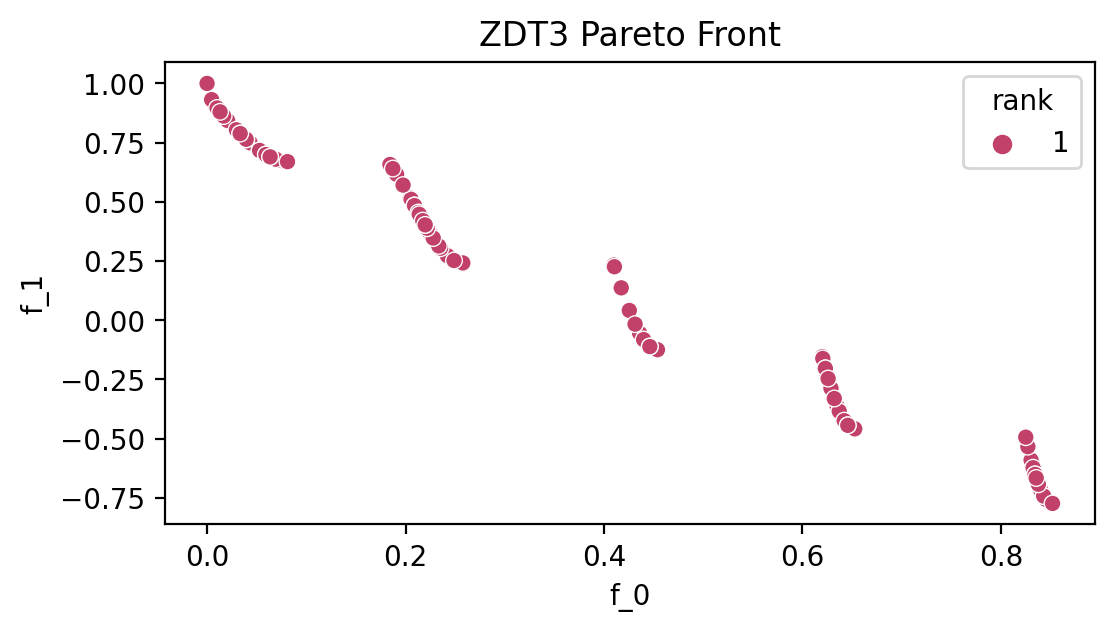

In [8]:
zdt3_df = pop_to_df(zdt3_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt3_df, **graph_kwargs)
ax.set_title("ZDT3 Pareto Front")

## ZDT4

A problem with numerous locally pareto-optimal fronts, 21^9 for the base problem of n=10.

In [9]:
zdt4_problem = ZDT4Problem()
zdt4_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt4_problem,
    **setup_real(zdt4_problem)
)

Text(0.5, 1.0, 'ZDT4 Pareto Front')

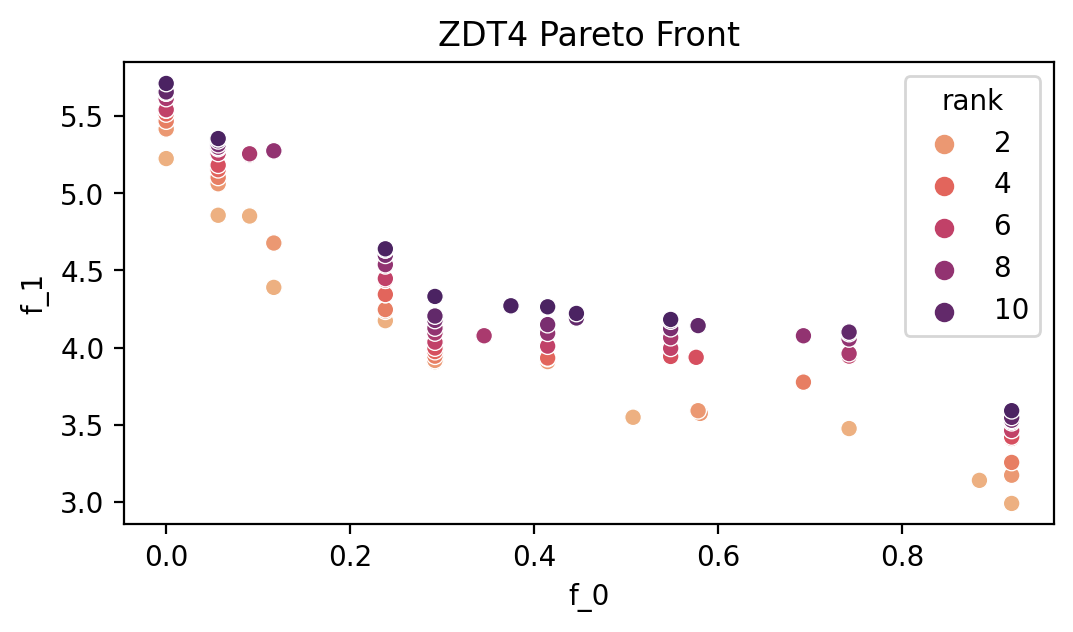

In [10]:
zdt4_df = pop_to_df(zdt4_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt4_df, **graph_kwargs)
ax.set_title("ZDT4 Pareto Front")

## ZDT5

A deceptive problem for testing evolution of binary phenomes.

In [11]:
zdt5_problem = ZDT5Problem()

zdt5_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt5_problem,
    representation=Representation(initialize=create_binary_sequence(zdt5_problem.phenome_length)),
    pipeline=make_pipeline(
        mutate_bitflip(expected_num_mutations=1)
    )
)

Text(0.5, 1.0, 'ZDT5 Pareto Front')

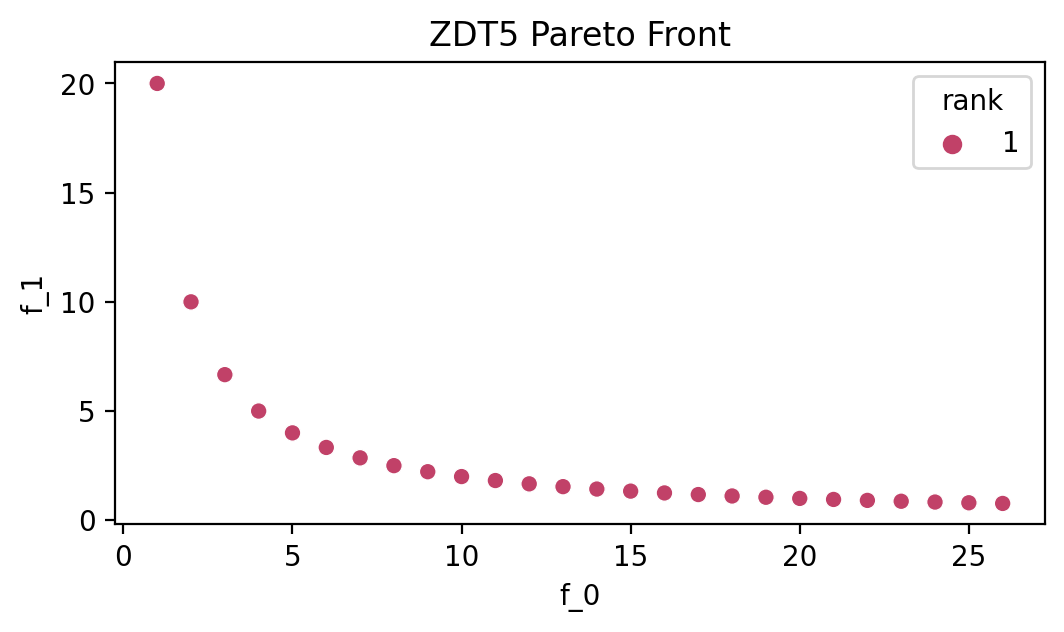

In [12]:
zdt5_df = pop_to_df(zdt5_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt5_df, **graph_kwargs)
ax.set_title("ZDT5 Pareto Front")

## ZDT6

A problem with a non-uniformly distributed pareto-optimal front, as well as a lower density of solutions nearer to said front. Optimal olutions are biased towards an f_0 of 1.0.

In [13]:
zdt6_problem = ZDT6Problem()
zdt6_pop = generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=zdt6_problem,
    **setup_real(zdt6_problem)
)

Text(0.5, 1.0, 'ZDT6 Pareto Front')

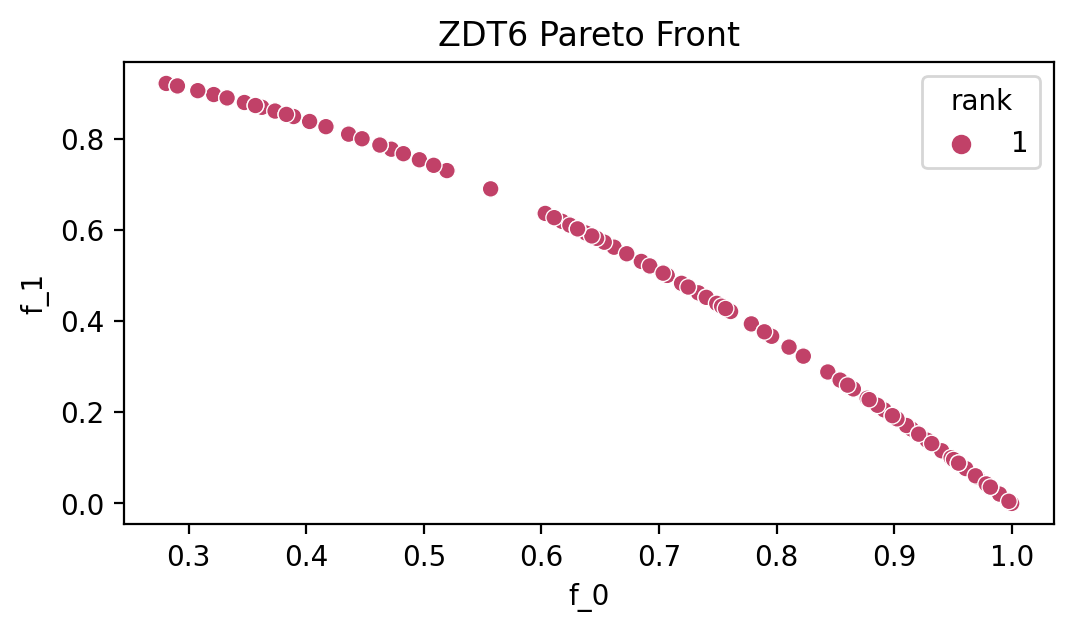

In [14]:
zdt6_df = pop_to_df(zdt6_pop)
fig, ax = plt.subplots()

sns.scatterplot(zdt6_df, **graph_kwargs)
ax.set_title("ZDT6 Pareto Front")